# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,recall_score,precision_score,f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from jupyterthemes import jtplot
jtplot.style()

%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 400

# Metric Functions

In [3]:
def run_baseline(mdl, 
                 X_train, y_train, X_test, y_test,
                 verbose=True):
    """Return a dict of model performance indicators."""
    
    results = {}
    
    # 1. Fit the model on the training set
    mdl.fit(X_train, y_train)

    # 2. Predict on the training and test sets
    y_pred_train = mdl.predict(X_train)
    y_pred_test = mdl.predict(X_test)
    pred_proba = mdl.predict_proba(X_test)[:,1]
    
    # 3. Train & test accuracy
    results['train_accuracy'] = accuracy_score(y_train, y_pred_train)
    results['test_accuracy'] = accuracy_score(y_test, y_pred_test)
    results['ROC_AUC'] = roc_auc_score(y_test, pred_proba)
    
    if verbose:
        print('Train Accuracy: ', results['train_accuracy'])
        print('Test Accuracy: ', results['test_accuracy'])
        print('\nOrder of classes: ', mdl.classes_)
    
    
    # 4. Test confusion matrix
    confusion_df = pd.DataFrame(\
                        data=confusion_matrix(y_test, y_pred_test),
                        index=[f'actual {target_class}' for target_class in mdl.classes_],
                        columns=[f'predicted {target_class}' for target_class in mdl.classes_])

    if verbose:
        print('\nTest Confusion Matrix: \n', confusion_df)
        print(classification_report(y_test, y_pred_test))
    
    # 5. Test recall and precision (if no samples, set recall/precision to 0)
    
    results['test_recall'] = recall_score(y_test, y_pred_test, 
                                          pos_label=1, zero_division=0)
    
    results['test_precision'] = precision_score(y_test, y_pred_test, 
                                                pos_label=1, zero_division=0)
    results['F1'] = f1_score(y_test,y_pred_test,
                             pos_label=1, zero_division=0)
        
    return results
    
    
def test_models(models, X_train, y_train, X_test, y_test,
                verbose=False):
    """Returns DataFrame of baseline results 
       given a dict `models` of names/sklearn models."""
    results = {}
    
    # Fit each model and store how it performs on the test set
    for name,model in models.items():
        if verbose:
            print('\nRunning')
        
        results[name] = run_baseline(model, 
                                     X_train, y_train, 
                                     X_test, y_test, 
                                     verbose=False)
        if verbose:
            print('Results: ', results[name])

    return pd.DataFrame.from_dict(results, orient='index').sort_index()
    

In [3]:
# Bring in data
path = '../thecap/Data/final.csv'
df = pd.read_csv(path, index_col='Date', parse_dates=True)
df = df.replace(to_replace=np.nan, method='bfill')
df.drop(columns=['Target','Close'],inplace=True)
df = df.replace(to_replace=np.nan, value=0)
dfcopy = df.copy()
df.head(2) 

,vol%_chg1d,vol%_chg3d,vol%_chg8d,range,range%,Target_1d,JPY%,Close_JPY,btc_tweets,btc_activeaddresses,btc_mining_profitability,btc_transactionfees,btc_median_transaction_fee,btc_mediantransactionvalue,sub_growth_%chg,btc_gtrends,buybitcoin_gtrends,ETH_gtrends,crypto_gtrends
Date,,,,,,,,,,,,,,,,,,,
2017-12-31,0.160589,-0.227634,0.517258,1.163969,0.065188,0.0,0.000923,112.769997,64989,847972,2.281,25.170,15.291,2182.0,0.007039,48.214286,0.0,1.295976,6.291338
2018-01-01,0.160589,-0.227634,0.517258,1.163969,0.065188,0.0,0.000923,112.769997,62044,842391,2.174,26.274,14.625,2104.0,0.007324,46.428571,0.0,1.295976,6.291338


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1070 entries, 2017-12-31 to 2020-12-03
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   vol%_chg1d                  1070 non-null   float64
 1   vol%_chg3d                  1070 non-null   float64
 2   vol%_chg8d                  1070 non-null   float64
 3   range                       1070 non-null   float64
 4   range%                      1070 non-null   float64
 5   Target_1d                   1070 non-null   float64
 6   JPY%                        1070 non-null   float64
 7   Close_JPY                   1070 non-null   float64
 8   btc_tweets                  1070 non-null   int64  
 9   btc_activeaddresses         1070 non-null   int64  
 10  btc_mining_profitability    1070 non-null   float64
 11  btc_transactionfees         1070 non-null   float64
 12  btc_median_transaction_fee  1070 non-null   float64
 13  btc_mediantrans

# Train Test Split + Scale


In [5]:
X = df._get_numeric_data().drop(columns=['Target_1d'])
y = df['Target_1d']
features = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    stratify = y,
                                                    random_state = 42)

#scale
sc = StandardScaler()
X_test_usc = X_test
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Null Model - Most Frequent Occuring Values


In [6]:
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train, y_train)

y_pred_train = dc.predict(X_train)
y_pred_test = dc.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, y_pred_train))
print('Test Accuracy: ', accuracy_score(y_test, y_pred_test))

Train Accuracy:  0.5269526952695269
Test Accuracy:  0.4968944099378882


# Instantiate + Fit + Score Base Models 

In [7]:
models = {'Most Frequent': DummyClassifier(strategy='most_frequent'),
          'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100,random_state=42),
          'Bagging Classifier': BaggingClassifier(n_estimators=100,random_state=42),
          'GradientBoosting Classifier': GradientBoostingClassifier(n_estimators=100,random_state=42),
          'DecisionTree Classifier': DecisionTreeClassifier(random_state=42),
          'Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
          'Logistic Regression': LogisticRegression(max_iter=100,random_state=42),
          'Random Forest': RandomForestClassifier(n_estimators=100),
          'ExtraTrees Classifier': ExtraTreesClassifier(n_estimators=100,random_state=42),
          'SVM': SVC(random_state=42,probability=True),
          'xgboost' : XGBClassifier(n_estimators=100,random_state=42)
          }

model_results = test_models(models, 
                            X_train, y_train, 
                            X_test, y_test, 
                            verbose=True)


model_results['train_test_diff'] = model_results['train_accuracy'] - model_results['test_accuracy'] 

model_results.sort_values(ascending=False,by='F1')


Running Most Frequent - DummyClassifier(strategy='most_frequent')
Results:  {'train_accuracy': 0.5269526952695269, 'test_accuracy': 0.4968944099378882, 'ROC_AUC': 0.5, 'test_recall': 1.0, 'test_precision': 0.4968944099378882, 'F1': 0.6639004149377593}

Running AdaBoost Classifier - AdaBoostClassifier(n_estimators=100, random_state=42)
Results:  {'train_accuracy': 0.7436743674367436, 'test_accuracy': 0.4968944099378882, 'ROC_AUC': 0.4849537037037038, 'test_recall': 0.5125, 'test_precision': 0.4939759036144578, 'F1': 0.5030674846625767}

Running Bagging Classifier - BaggingClassifier(n_estimators=100, random_state=42)
Results:  {'train_accuracy': 1.0, 'test_accuracy': 0.5217391304347826, 'ROC_AUC': 0.504783950617284, 'test_recall': 0.5875, 'test_precision': 0.5164835164835165, 'F1': 0.5497076023391813}

Running GradientBoosting Classifier - GradientBoostingClassifier(random_state=42)
Results:  {'train_accuracy': 0.8932893289328933, 'test_accuracy': 0.40372670807453415, 'ROC_AUC': 0.4524

,train_accuracy,test_accuracy,ROC_AUC,test_recall,test_precision,F1,train_test_diff
Most Frequent,0.526953,0.496894,0.500000,1.0000,0.496894,0.663900,0.030058
SVM,0.643564,0.490683,0.460340,0.6625,0.490741,0.563830,0.152881
DecisionTree Classifier,1.000000,0.527950,0.528395,0.6000,0.521739,0.558140,0.472050
Bagging Classifier,1.000000,0.521739,0.504784,0.5875,0.516484,0.549708,0.478261
Logistic Regression,0.563256,0.478261,0.490432,0.6125,0.480392,0.538462,0.084995
ExtraTrees Classifier,1.000000,0.503106,0.510648,0.5625,0.500000,0.529412,0.496894
xgboost,1.000000,0.503106,0.500617,0.5500,0.500000,0.523810,0.496894
Random Forest,1.000000,0.478261,0.475154,0.5375,0.477778,0.505882,0.521739
AdaBoost Classifier,0.743674,0.496894,0.484954,0.5125,0.493976,0.503067,0.246780
Nearest Neighbors,0.768977,0.472050,0.494522,0.5125,0.471264,0.491018,0.296927


# Poly Features

In [8]:
dfcopy.head(2)

,vol%_chg1d,vol%_chg3d,vol%_chg8d,range,range%,Target_1d,JPY%,Close_JPY,btc_tweets,btc_activeaddresses,btc_mining_profitability,btc_transactionfees,btc_median_transaction_fee,btc_mediantransactionvalue,sub_growth_%chg,btc_gtrends,buybitcoin_gtrends,ETH_gtrends,crypto_gtrends
Date,,,,,,,,,,,,,,,,,,,
2017-12-31,0.160589,-0.227634,0.517258,1.163969,0.065188,0.0,0.000923,112.769997,64989,847972,2.281,25.170,15.291,2182.0,0.007039,48.214286,0.0,1.295976,6.291338
2018-01-01,0.160589,-0.227634,0.517258,1.163969,0.065188,0.0,0.000923,112.769997,62044,842391,2.174,26.274,14.625,2104.0,0.007324,46.428571,0.0,1.295976,6.291338


In [9]:
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)
polydf= pd.DataFrame(X_poly,index=dfcopy.index, columns=poly.get_feature_names(features))
polydftarget = pd.merge(dfcopy['Target_1d'],polydf,left_index = True,right_index= True)
# to CSV data folder
polydftarget.to_csv('../thecap/Data/polyfeatures.csv')
polydf.head(2)

,vol%_chg1d,vol%_chg3d,vol%_chg8d,range,range%,JPY%,Close_JPY,btc_tweets,btc_activeaddresses,btc_mining_profitability,btc_transactionfees,btc_median_transaction_fee,btc_mediantransactionvalue,sub_growth_%chg,btc_gtrends,buybitcoin_gtrends,ETH_gtrends,crypto_gtrends,vol%_chg1d^2,vol%_chg1d vol%_chg3d,vol%_chg1d vol%_chg8d,vol%_chg1d range,vol%_chg1d range%,vol%_chg1d JPY%,vol%_chg1d Close_JPY,vol%_chg1d btc_tweets,vol%_chg1d btc_activeaddresses,vol%_chg1d btc_mining_profitability,vol%_chg1d btc_transactionfees,vol%_chg1d btc_median_transaction_fee,vol%_chg1d btc_mediantransactionvalue,vol%_chg1d sub_growth_%chg,vol%_chg1d btc_gtrends,vol%_chg1d buybitcoin_gtrends,vol%_chg1d ETH_gtrends,vol%_chg1d crypto_gtrends,vol%_chg3d^2,vol%_chg3d vol%_chg8d,vol%_chg3d range,vol%_chg3d range%,vol%_chg3d JPY%,vol%_chg3d Close_JPY,vol%_chg3d btc_tweets,vol%_chg3d btc_activeaddresses,vol%_chg3d btc_mining_profitability,vol%_chg3d btc_transactionfees,vol%_chg3d btc_median_transaction_fee,vol%_chg3d btc_mediantransactionvalue,vol%_chg3d sub_growth_%chg,vol%_chg3d btc_gtrends,...,btc_activeaddresses sub_growth_%chg,btc_activeaddresses btc_gtrends,btc_activeaddresses buybitcoin_gtrends,btc_activeaddresses ETH_gtrends,btc_activeaddresses crypto_gtrends,btc_mining_profitability^2,btc_mining_profitability btc_transactionfees,btc_mining_profitability btc_median_transaction_fee,btc_mining_profitability btc_mediantransactionvalue,btc_mining_profitability sub_growth_%chg,btc_mining_profitability btc_gtrends,btc_mining_profitability buybitcoin_gtrends,btc_mining_profitability ETH_gtrends,btc_mining_profitability crypto_gtrends,btc_transactionfees^2,btc_transactionfees btc_median_transaction_fee,btc_transactionfees btc_mediantransactionvalue,btc_transactionfees sub_growth_%chg,btc_transactionfees btc_gtrends,btc_transactionfees buybitcoin_gtrends,btc_transactionfees ETH_gtrends,btc_transactionfees crypto_gtrends,btc_median_transaction_fee^2,btc_median_transaction_fee btc_mediantransactionvalue,btc_median_transaction_fee sub_growth_%chg,btc_median_transaction_fee btc_gtrends,btc_median_transaction_fee buybitcoin_gtrends,btc_median_transaction_fee ETH_gtrends,btc_median_transaction_fee crypto_gtrends,btc_mediantransactionvalue^2,btc_mediantransactionvalue sub_growth_%chg,btc_mediantransactionvalue btc_gtrends,btc_mediantransactionvalue buybitcoin_gtrends,btc_mediantransactionvalue ETH_gtrends,btc_mediantransactionvalue crypto_gtrends,sub_growth_%chg^2,sub_growth_%chg btc_gtrends,sub_growth_%chg buybitcoin_gtrends,sub_growth_%chg ETH_gtrends,sub_growth_%chg crypto_gtrends,btc_gtrends^2,btc_gtrends buybitcoin_gtrends,btc_gtrends ETH_gtrends,btc_gtrends crypto_gtrends,buybitcoin_gtrends^2,buybitcoin_gtrends ETH_gtrends,buybitcoin_gtrends crypto_gtrends,ETH_gtrends^2,ETH_gtrends crypto_gtrends,crypto_gtrends^2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31,0.160589,-0.227634,0.517258,1.163969,0.065188,0.000923,112.769997,64989.0,847972.0,2.281,25.170,15.291,2182.0,0.007039,48.214286,0.0,1.295976,6.291338,0.025789,-0.036555,0.083066,0.18692,0.010468,0.000148,18.10958,10436.494994,136174.668533,0.366303,4.042016,2.455561,350.404408,0.001130,7.742666,0.0,0.208119,1.010317,0.051817,-0.117746,-0.264959,-0.014839,-0.00021,-25.670286,-14793.706235,-193027.260974,-0.519233,-5.729548,-3.480752,-496.697395,-0.001602,-10.975211,...,5968.591707,4.088436e+07,0.0,1.098951e+06,5.334878e+06,5.202961,57.412770,34.878771,4977.142,0.016055,109.976786,0.0,2.956122,14.350541,633.528900,384.87447,54920.940,0.177163,1213.553571,0.0,32.619719,158.352968,233.814681,33364.962,0.107628,737.244643,0.0,19.816771,96.200844,4761124.0,15.358369,105203.571429,0.0,2827.819880,13727.698692,0.000050,0.339364,0.0,0.009122,0.044283,2324.617347,0.0,62.484563,303.332350,0.0,0.0,0.0,1.679554,8.153423,39.580929
2018-01-01,0.160589,-0.227634,0.517258,1.163969,0.065188,0.000923,112.769997,62044.0,842391.0,2.174,26.274,14.625,2104.0,0.00

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_poly,
                                                    y,
                                                    test_size = 0.15,
                                                    random_state = 42)

#scale
sc = StandardScaler()
X_test_usc = X_test
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Instantiate + Fit + Score Base Models with Poly Features

In [11]:
models = {
          'Most Frequent': DummyClassifier(strategy='most_frequent'),
          'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100,random_state=42),
          'Bagging Classifier': BaggingClassifier(n_estimators=100,random_state=42),
          'GradientBoosting Classifier': GradientBoostingClassifier(n_estimators=100,random_state=42),
          'DecisionTree Classifier': DecisionTreeClassifier(random_state=42),
          'Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
          'Logistic Regression': LogisticRegression(max_iter=100,random_state=42),
          'Random Forest': RandomForestClassifier(n_estimators=100),
          'ExtraTrees Classifier': ExtraTreesClassifier(n_estimators=100,random_state=42),
          'SVM': SVC(random_state=42,probability=True),
          'xgboost' : XGBClassifier(n_estimators=100,random_state=42)
          }

model_results = test_models(models, 
                            X_train, y_train, 
                            X_test, y_test, 
                            verbose=True)

model_results['train_test_diff'] = model_results['train_accuracy'] - model_results['test_accuracy'] 

model_results.sort_values(ascending=False,by='F1')


Running Most Frequent - DummyClassifier(strategy='most_frequent')
Results:  {'train_accuracy': 0.5269526952695269, 'test_accuracy': 0.4968944099378882, 'ROC_AUC': 0.5, 'test_recall': 1.0, 'test_precision': 0.4968944099378882, 'F1': 0.6639004149377593}

Running AdaBoost Classifier - AdaBoostClassifier(n_estimators=100, random_state=42)
Results:  {'train_accuracy': 0.8558855885588559, 'test_accuracy': 0.4658385093167702, 'ROC_AUC': 0.5066358024691358, 'test_recall': 0.5125, 'test_precision': 0.4659090909090909, 'F1': 0.4880952380952381}

Running Bagging Classifier - BaggingClassifier(n_estimators=100, random_state=42)
Results:  {'train_accuracy': 1.0, 'test_accuracy': 0.5403726708074534, 'ROC_AUC': 0.5381944444444445, 'test_recall': 0.65, 'test_precision': 0.5306122448979592, 'F1': 0.5842696629213483}

Running GradientBoosting Classifier - GradientBoostingClassifier(random_state=42)
Results:  {'train_accuracy': 0.9592959295929593, 'test_accuracy': 0.5217391304347826, 'ROC_AUC': 0.518364

/Users/j_b/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results:  {'train_accuracy': 1.0, 'test_accuracy': 0.4968944099378882, 'ROC_AUC': 0.49691358024691357, 'test_recall': 0.5375, 'test_precision': 0.4942528735632184, 'F1': 0.5149700598802395}

Running ExtraTrees Classifier - ExtraTreesClassifier(random_state=42)
Results:  {'train_accuracy': 1.0, 'test_accuracy': 0.5279503105590062, 'ROC_AUC': 0.49984567901234567, 'test_recall': 0.575, 'test_precision': 0.5227272727272727, 'F1': 0.5476190476190476}

Running SVM - SVC(probability=True, random_state=42)
Results:  {'train_accuracy': 0.6336633663366337, 'test_accuracy': 0.4968944099378882, 'ROC_AUC': 0.534104938271605, 'test_recall': 0.7875, 'test_precision': 0.49606299212598426, 'F1': 0.608695652173913}

Running xgboost - XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=Non

,train_accuracy,test_accuracy,ROC_AUC,test_recall,test_precision,F1,train_test_diff
Most Frequent,0.526953,0.496894,0.500000,1.0000,0.496894,0.663900,0.030058
SVM,0.633663,0.496894,0.534105,0.7875,0.496063,0.608696,0.136769
Bagging Classifier,1.000000,0.540373,0.538194,0.6500,0.530612,0.584270,0.459627
GradientBoosting Classifier,0.959296,0.521739,0.518364,0.6250,0.515464,0.564972,0.437557
ExtraTrees Classifier,1.000000,0.527950,0.499846,0.5750,0.522727,0.547619,0.472050
Nearest Neighbors,0.775578,0.503106,0.491821,0.6000,0.500000,0.545455,0.272472
xgboost,1.000000,0.527950,0.495525,0.5625,0.523256,0.542169,0.472050
Random Forest,1.000000,0.496894,0.496914,0.5375,0.494253,0.514970,0.503106
DecisionTree Classifier,1.000000,0.509317,0.509259,0.5000,0.506329,0.503145,0.490683
AdaBoost Classifier,0.855886,0.465839,0.506636,0.5125,0.465909,0.488095,0.390047


In [37]:
#Base Line
y_test.value_counts(normalize=True)

0.0    0.503106
1.0    0.496894
Name: Target_1d, dtype: float64

In [39]:
rs.best_score_

0.5346534653465347

In [40]:
def metrics(y_test, y_predict, pred_proba):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['Predicted Down', 'Predicted Up/Unch'], 
                            columns=['Actual Down', 'Actual Up/Unch']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')
    print('ROC_AUC SCORE %s ' %roc_auc_score(y_test, pred_proba))

In [41]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.5093167701863354  

----------------------------------------------------------------
                   Actual Down  Actual Up/Unch
Predicted Down               2              79
Predicted Up/Unch            0              80 

-----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.02      0.05        81
         1.0       0.50      1.00      0.67        80

    accuracy                           0.51       161
   macro avg       0.75      0.51      0.36       161
weighted avg       0.75      0.51      0.36       161

-----------------------------------------------------------------
ROC_AUC SCORE 0.4933641975308642 


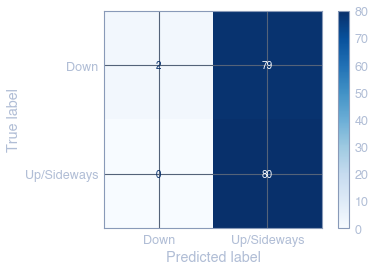

In [42]:
plot_confusion_matrix(rs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Down', 'Up/Sideways']);

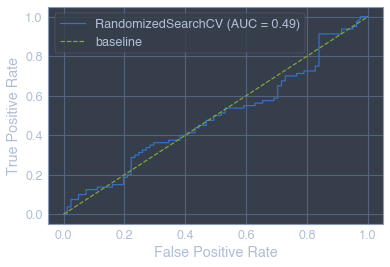

In [43]:
plot_roc_curve(rs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [53]:
dum = DummyClassifier(strategy='most_frequent')
dum.fit(X_train,y_train)

preds = dum.predict(X_test)

pred_proba = dum.predict_proba(X_test)[:,1]

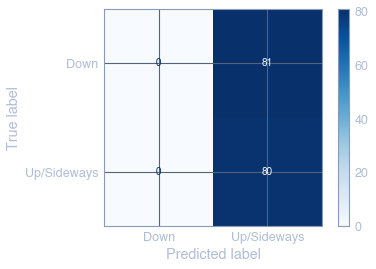

In [54]:
plot_confusion_matrix(dum, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Down', 'Up/Sideways']);

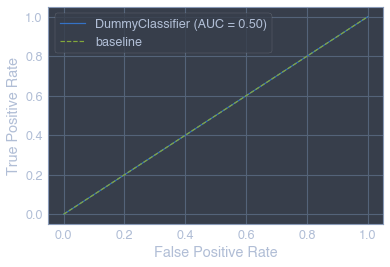

In [55]:
plot_roc_curve(dum, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [56]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.4968944099378882  

----------------------------------------------------------------
                   Actual Down  Actual Up/Unch
Predicted Down               0              81
Predicted Up/Unch            0              80 

-----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        81
         1.0       0.50      1.00      0.66        80

    accuracy                           0.50       161
   macro avg       0.25      0.50      0.33       161
weighted avg       0.25      0.50      0.33       161

-----------------------------------------------------------------
ROC_AUC SCORE 0.5 


/Users/j_b/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
models = {'SVM_Recall Tune': rs,
          'SVM_Balanced Tune': gs4,
          'Most Frequent': DummyClassifier(strategy='most_frequent'),
          }

model_results = test_models(models, 
                            X_train, y_train, 
                            X_test, y_test, 
                            verbose=True)

model_results['train_test_diff'] = model_results['train_accuracy'] - model_results['test_accuracy'] 

model_results.sort_values(ascending=False,by='F1')

NameError: name 'rs' is not defined